<a href="https://colab.research.google.com/github/bwilson7/thinkful_drills/blob/master/rfc_spark_batch_02_26_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, you'll learn the basics of working with Spark in batch mode to build a random forest classifier. Note that this notebook is intended to be run on Google Colaboratory.

## Spark and Colaboratory setup

First, there's some configration specific to running Spark on Colaboratory that we'll need to attend to. Run these cells to set everything up.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [2]:
# Install spark-related depdencies for Python
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 215.7MB 98kB/s 
     |████████████████████████████████| 204kB 40.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=6ca79e8a02ba640e84a6693142356582dab25dc85eed757e54a35f25c30541cb
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [4]:
# Point Colaboratory to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##  Import dependencies

Next, we need to import the tools we'll need from PySpark. The imports below allow us to connect to the Spark server, load our data, clean it, and prepare, execute, and evaluate a model.

In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.sql.functions import isnan, when, count, col

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

## Set our constants

Next, we create a set of constants that we can refer to throughout the notebook. These are values that the rest of our code needs to run, but that we might need to change at some point (for instance, if the location of our data changes). 

If you saved the relevant datasets in the folders suggested in the previous checkpoint (link), you can use the below code chunk as is. If you saved the datasets elsewhere on your Google Drive, modify the file path after the `My Drive` folder. 

Regardless of the exact file path, these datasets **must** be stored on Google Drive!

In [0]:
CSV_PATH = "/content/gdrive/My Drive/colab_datasets/allData.csv" 
CSV_ACTIVITY_LABEL_PATH = "/content/gdrive/My Drive/colab_datasets/activity_labels.csv"
APP_NAME = "UCI HAR Random Forest Example"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

## Connect to the server and load data

Now we're ready to connect to the Spark server. We do that (relying on the constants set above) and then load our labels (loaded into `activity_labels`) and activity data (loaded into `df`). 

In [0]:
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
activity_labels = spark.read.options(inferschema = "true").csv(CSV_ACTIVITY_LABEL_PATH)
df = spark.read.options(inferschema = "true").csv(CSV_PATH)

## Validate the data

If our data has been properly cleaned and prepared, it will meet the following criteria, which we'll verify in just a moment:

* The dataframe shape should be 10,299 rows by 562 columns
* All feature columns should be doubles. Note that one of the columns is for our labels and it will not be double.
* There should be no nulls. This point is crucial because Spark will fail to build our vector variables for our classifier if there are any null values.

Let's confirm these points.

In [8]:
# Confirm the dataframe shape is 10,299 rows by 562 columns
print(f"Dataset shape is {df.count():d} rows by {len(df.columns):d} columns.")

Dataset shape is 10299 rows by 562 columns.


In [9]:
# Confirm that all feature columns are doubles via a list comprehension
# We're expecting 561 of 562 here, accounting for the labels column
double_cols = [col[0] for col in df.dtypes if col[1] == 'double']
print(f"{len(double_cols):d} columns out of {len(df.columns):d} total are type double.")

561 columns out of 562 total are type double.


In [10]:
# Confirm there are no null values. We use the dataframe select method to build a 
# list that is then converted to a Python dict. This way it's easy to sum up the nulls.
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
                         for c in df.columns]).toPandas().to_dict(orient='records')

print(f"There are {sum(null_counts[0].values()):d} null values in the dataset.")

There are 0 null values in the dataset.


In [11]:
df

DataFrame[_c0: int, _c1: double, _c2: double, _c3: double, _c4: double, _c5: double, _c6: double, _c7: double, _c8: double, _c9: double, _c10: double, _c11: double, _c12: double, _c13: double, _c14: double, _c15: double, _c16: double, _c17: double, _c18: double, _c19: double, _c20: double, _c21: double, _c22: double, _c23: double, _c24: double, _c25: double, _c26: double, _c27: double, _c28: double, _c29: double, _c30: double, _c31: double, _c32: double, _c33: double, _c34: double, _c35: double, _c36: double, _c37: double, _c38: double, _c39: double, _c40: double, _c41: double, _c42: double, _c43: double, _c44: double, _c45: double, _c46: double, _c47: double, _c48: double, _c49: double, _c50: double, _c51: double, _c52: double, _c53: double, _c54: double, _c55: double, _c56: double, _c57: double, _c58: double, _c59: double, _c60: double, _c61: double, _c62: double, _c63: double, _c64: double, _c65: double, _c66: double, _c67: double, _c68: double, _c69: double, _c70: double, _c71: dou

## Set up and run our classifier in Spark

After confirming our data is clean, we're ready to reshape the data and run the random forest model.

In Spark, we manipulate the data to work in a Spark pipeline, define each of the steps in the pipeline, chain them together, and finally run the pipeline.

Apache Spark classifiers expect 2 columns of input:

1. __labels__: an indexed set of numeric variables that represent the classification from the set of features we provide.
2. __features__: an indexed, vector variable that contains all of the feature values in each row. 

In order to do this, we need to create these 2 columns from our dataset - the data is there, but not yet in a format we can use for the classifier.

To create the indexed labels column, we'll create a column called `indexedLabel` using the `StringIndexer` method. We use the column `_c0` as the source for our label index since that contains our labels. The column contains only one value per index.
    
To create the indexed features column, we'll need to do two things. First, we'll create the vector of features using the `VectorAssembler` method. To create this vector, we'll need to use all 561 numeric columns from our data frame. The vector assembler will create a new column called `features`, and each row of this column will contain a 561-element vector that is built from the 561 features in the dataset.

Finally, we'll complete the data preparation by creating an indexed vector from the `features` column. We'll call this vector `indexedFeatures`.
    
Since the classifier expects indexed labels and an indexed vector column of data, we'll use the `indexedLabel` and `indexedFeatures` as inputs to our random forest classifier.

In [0]:
# Generate our feature vector.
# Note that we're doing the work on the `df` object - we don't create new dataframes, 
# just add columns to the one we already are using.

# the transform method creates the column.

df = VectorAssembler(inputCols=double_cols, outputCol="features").transform(df)

Let's confirm that the features are there. It's easy to do this in Apache Spark using the `select` and `show` methods on the dataframe.  

In [12]:
df.select("_c0", "features").show(5)

+---+--------------------+
|_c0|            features|
+---+--------------------+
|  5|[0.289,-0.0203,-0...|
|  5|[0.278,-0.0164,-0...|
|  5|[0.28,-0.0195,-0....|
|  5|[0.279,-0.0262,-0...|
|  5|[0.277,-0.0166,-0...|
+---+--------------------+
only showing top 5 rows



Now we're ready to build the indexers, split our data for training and testing, define our model, and finally chain everything together into a pipeline.

__It's important to note that when we execute this cell, we're not actually running our model. At this point, we're only defining its parameters__.

In [0]:
# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="_c0", outputCol="indexedLabel").fit(df)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = df.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

This next cell runs the pipeline, delivering a trained model at the end of the process.

In [0]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [17]:
model.rf.featureImportances

AttributeError: ignored

It is now easy to test our model and make predictions simply by using the model's `transform` method on the `testData` dataset.

In [0]:
# Make predictions.
predictions = model.transform(testData)

## Evaluate the model

Now we can use the MulticlassClassificationEvaluator to test the model's accuracy.

In [56]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName:'weightedPrecision'})
recall = evaluator.evaluate(predictions, {evaluator.metricName:'weightedRecall'})
f1 = evaluator.evaluate(predictions, {evaluator.metricName:'f1'})

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")
print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("f1-score = {}".format(f1))

Test Error = 0.0916988
Accuracy = 0.908301
Precision = 0.909863104846345
Recall = 0.9083011583011582
f1-score = 0.9080556945158635


In [80]:
trainingData.count()

8192

In [84]:
predictions.show()

+---+-----+--------+-------+-------+--------+------+--------+-------+-------+--------+-------+-------+-------+--------+------+-------+------+------+------+-------+-------+-------+------+------+-------+-------+-------+-------+--------+-------+--------+-------+-------+--------+-------+-------+-------+-------+-------+-------+-----+------+-------+------+------+------+------+------+------+-----+------+--------+-----+------+--------+------+-----+------+------+------+------+------+------+------+------+------+-----+------+-----+-------+-------+-------+-------+--------+--------+--------+--------+-------+------+------+--------+--------+--------+------+--------+-------+-------+--------+-------+-------+------+------+-------+-------+------+-------+------+------+------+-------+-------+------+-----+-----+-----+------+-------+--------+-------+-------+-------+--------+------+--------+-------+--------+------+-------+--------+------+-------+-------+-------+------+------+-------+------+--------+------+---

## Next Steps

We've seen how to prepare data and build a classifier in Spark. You might want to play around with this notebook and learn more about how Spark works. Here are some ideas:

- Look at the set of labels, and see if there are any features that would make sense to combine. Spark allows you to map values into a new column.
- Identify the most important features among the 561 source features (using PCA or something similar), then reduce the feature set and see if the model performs better.
- Modify the settings of the random forest to see if the performance improves.
- Use Spark's tools to find other techniques to evaluate the performance of your model. See if you can figure out how to generate an ROC plot, find the AUC value, or plot a confusion matrix.

In [42]:
df.select('_c0').distinct().rdd.map(lambda r: r[0]).collect()

[1, 6, 3, 5, 4, 2]

In [92]:
conf_matrix = predictions.crosstab('indexedLabel', 'prediction')
conf_matrix.show()

+-----------------------+---+---+---+---+---+---+
|indexedLabel_prediction|0.0|1.0|2.0|3.0|4.0|5.0|
+-----------------------+---+---+---+---+---+---+
|                    0.0|393|  0|  0|  0|  1|  0|
|                    5.0|  0|  0|  0| 25| 28|233|
|                    1.0|  0|323| 49|  0|  1|  0|
|                    2.0|  0| 40|313|  0|  0|  0|
|                    3.0|  0|  0|  0|313| 13|  6|
|                    4.0|  0|  0|  0| 20|307|  7|
+-----------------------+---+---+---+---+---+---+



In [93]:
RF_NUM_TREES = 200
RF_MAX_DEPTH = 10
RF_NUM_BINS = 32

#changing up some of the rf params and reevaluating performance
rf = RandomForestClassifier(
    labelCol="indexedLabel",
    featuresCol="indexedFeatures",
    numTrees=RF_NUM_TREES,
    maxDepth=RF_MAX_DEPTH,
    seed=8,
    impurity='entropy'
)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName:'weightedPrecision'})
recall = evaluator.evaluate(predictions, {evaluator.metricName:'weightedRecall'})
f1 = evaluator.evaluate(predictions, {evaluator.metricName:'f1'})

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")
print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("f1-score = {}".format(f1))

conf_matrix = predictions.crosstab('indexedLabel', 'prediction')
print(conf_matrix.show())

Test Error = 0.0256289
Accuracy = 0.974371
Precision = 0.9747688080839996
Recall = 0.9743711438063598
f1-score = 0.9743939381971468
+-----------------------+---+---+---+---+---+---+
|indexedLabel_prediction|0.0|1.0|2.0|3.0|4.0|5.0|
+-----------------------+---+---+---+---+---+---+
|                    0.0|394|  0|  0|  0|  1|  0|
|                    5.0|  0|  0|  0|  0|  9|261|
|                    1.0|  0|377| 12|  0|  0|  0|
|                    2.0|  0| 25|353|  0|  0|  0|
|                    3.0|  0|  0|  0|362|  4|  1|
|                    4.0|  0|  0|  0|  0|306|  2|
+-----------------------+---+---+---+---+---+---+

None


Increasing the number of trees and max_depth definitely improved the model. I still need to figure out how to compare training statistics to test so that the overfit can be evaluated. However, with precision and recall both nearing 1 it's unlikely that there is a very large overfit problem. 

In [18]:
rfModel = model.stages[2]
print(rfModel)

RandomForestClassificationModel (uid=RandomForestClassifier_6c0094faa0bd) with 10 trees


In [0]:
feat_important = pd.DataFrame()
feat_important['values'] = rfModel.featureImportances.values
feat_important['feature'] = rfModel.featureImportances.indices
feat_important['feature'] = feat_important['feature'].astype('str')
feat_important = feat_important.sort_values(by='values', ascending=False).reset_index(drop=True)

In [97]:
feat_important.head()

,values,feature
0,0.059097,177
1,0.058154,42
2,0.041932,56
3,0.037734,558
4,0.035050,49


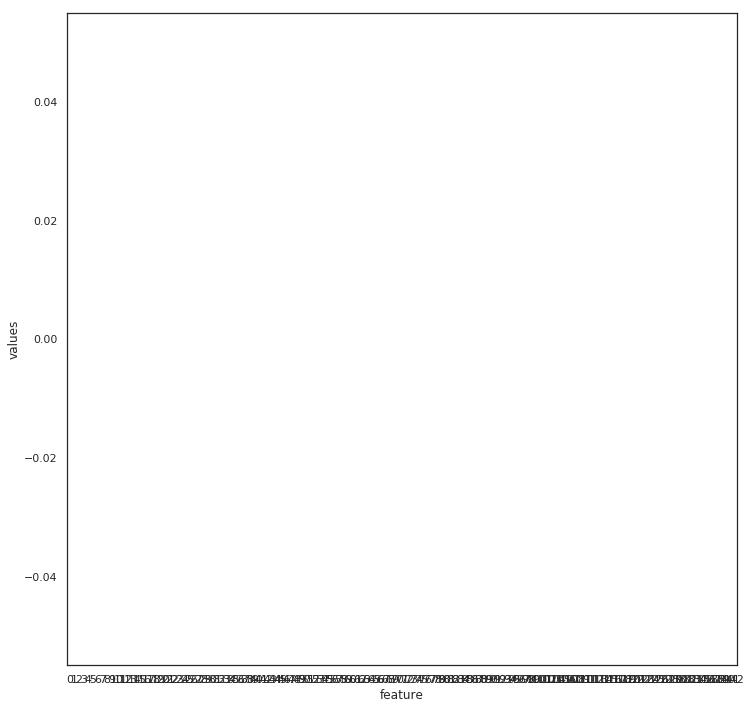

In [98]:
plt.figure(figsize=(12,12))
sns.set(style='white')
sns.barplot(
    x=feat_important['feature'],
    y=feat_important['values'],
    order=feat_important.index
)
plt.show()

In [0]:
s